In [22]:
import torch_struct
import torch
import matplotlib.pyplot as plt
import matplotlib
import math
from collections import OrderedDict
from typing import Dict
from tqdm.notebook import tqdm

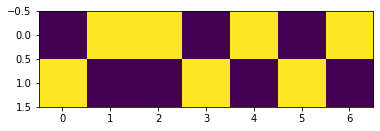

In [23]:
batch, N, C = 3, 7, 2
def show_chain(chain):
    plt.imshow(chain.detach().sum(-1).transpose(0, 1))

# batch, N, z_n, z_n_1
log_potentials = torch.rand(batch, N, C, C)
dist = torch_struct.LinearChainCRF(log_potentials)
show_chain(dist.argmax[0])

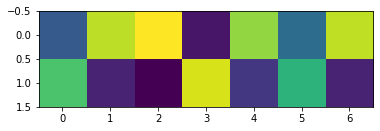

In [24]:
show_chain(dist.marginals[0])

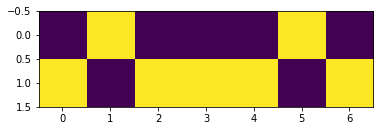

In [25]:
event = dist.to_event(torch.tensor([[0, 1, 0, 1, 1, 1, 0, 1]]), 2)
show_chain(event[0])

## Let's first write some code for converting a tokenization lattice to a linear chain CRF

In [26]:
# first let's define a simple weighted vocabulary
vocabulary = OrderedDict([(k,i) for i, k in enumerate(["[PAD]", "h", "a", "t", "e", "at", "hat", "ate", "hate"])])
embedding = torch.nn.Embedding(num_embeddings=len(vocabulary), embedding_dim=1, padding_idx=0)
weights = {
    "[PAD]": 1.0,
    "h": 1.0,
    "a": 1.0,
    "t": 1.0,
    "e": 1.0,
    "at": 2.0,
    "hat": 3.0,
    "ate": 4.0,
    "hate": 5.0
}
for unit in weights.keys():
    embedding.weight.data[vocabulary[unit]] = math.log(weights[unit])
print(embedding.weight.data)

tensor([[0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.6931],
        [1.0986],
        [1.3863],
        [1.6094]])


In [27]:
# now let's make the transition matrices
def construct_chain(N: int, chunk: str, vocab: Dict[str, int], weights: torch.nn.Embedding, continuing_subword_prefix: str=None):
    mask = torch.zeros((N, N, N), dtype=torch.float) # whenever a element of a matrix is from weights, set to 1
    ids = torch.zeros((N, N, N), dtype=torch.int)
    default_chain_weights = construct_default_chain_weights(N, len(chunk))
    for s in range(len(chunk)):
        for l in range(len(chunk) - s + 1):
            unit = chunk[s:s + l]
            unit = unit if continuing_subword_prefix is None or s == 0 else continuing_subword_prefix + unit
            if unit in vocab:
                mask[s+l-1, l-1, 0] = 1
                ids[s+l-1, l-1, 0] = vocab[unit]
    log_potentials = mask * weights(ids).squeeze(-1) + torch.log((1-mask) * default_chain_weights + mask)
    return log_potentials

def construct_default_chain_weights(N: int, L: int):
    potentials = torch.zeros((N, N, N), dtype=torch.float) # fill with pad (id=0)
    for i in range(L-1):
        potentials[i, :i+1, 1:i+2] = torch.eye(i+1)
    return potentials

print(construct_default_chain_weights(6, 6))
print(construct_chain(6, "hate", vocabulary, embedding))

tensor([[[0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 1., 0.],
         [0.

In [28]:
# now let's use torch-struct to compute log_potentials
batch, N, C = 1024, 20, 20
def show_chain(chain):
    plt.imshow(chain.cpu().detach().sum(-1).transpose(0, 1))
# batch, N, z_n, z_n_1
log_potentials = construct_chain(N, "hate", vocabulary, embedding).unsqueeze(0).repeat(batch,1,1,1).transpose(-1, -2)
print(log_potentials.size())
lengths = torch.tensor([5] + [N+1] * (batch-1)).to("cuda:1")
print(lengths)
# for i in tqdm(range(100)):
#     dist = torch_struct.LinearChainCRF(log_potentials.to("cuda:1"), lengths=lengths)
#     dist.partition[0]
#     # show_chain(dist.marginals[0])
#     # show_chain(dist.argmax[0])

torch.Size([1024, 20, 20, 20])
tensor([ 5, 21, 21,  ..., 21, 21, 21], device='cuda:1')


# Let's try to implement our own version using genbmm

In [29]:
import genbmm


In [76]:
def construct_chain_mask(N: int, chunk: str, vocab: Dict[str, int], weights: torch.nn.Embedding, continuing_subword_prefix: str=None, reverse=False):
    """
    reverse=False
    [ h a  t   e   ]
    [   ha at  te  ]
    [      hat ate ]
    [          hate]
    """
    """
    reverse=True
    first do this
    [ h   a   t  e]
    [ ha  at  te  ]
    [ hat ate     ]
    [ hate        ]
    then flip left to right
    """
    mask = torch.zeros((N, N), dtype=torch.float) # whenever a element of a matrix is from weights, set to 1
    ids = torch.zeros((N, N), dtype=torch.int)
    for s in range(len(chunk)):
        for l in range(len(chunk) - s + 1):
            unit = chunk[s:s + l]
            unit = unit if continuing_subword_prefix is None or s == 0 else continuing_subword_prefix + unit
            if unit in vocab:
                if not reverse:
                    mask[l-1, s+l-1] = 1
                    ids[l-1, s+l-1] = vocab[unit]
                else:
                    mask[l-1, len(chunk)-s-1] = 1
                    ids[l-1, len(chunk)-s-1] = vocab[unit]
                    
    return embedding(ids).squeeze(-1), mask


def forward(edge_matrix, mask, lengths):
    edge_log_potentials = torch.ones_like(edge_matrix) * (-1e9)
    edge_log_potentials[mask.to(torch.bool)] = 0.0
    edge_log_potentials += edge_matrix
    
    log_alphas = [mask.new_zeros(edge_matrix.size(0))]
    n = edge_matrix.size(1)
    bm = mask.to(torch.bool)
    for i in range(n):
        maski = (bm & torch.diag_embed(mask.new_ones(n-i, dtype=torch.bool), offset=i).unsqueeze(0)).to(torch.float)
        update = log_alphas[-1][:,None, None] * maski
        edge_log_potentials = edge_log_potentials +  update
        log_alphas.append(torch.logsumexp(edge_log_potentials[:, :,i], -1))
    return torch.gather(torch.stack(log_alphas), 0, lengths.unsqueeze(0)), edge_log_potentials #[log_alphas[l][i] for i, l in enumerate(lengths)]


N=20
b = 10
gmask = torch.zeros(N,N,N, dtype=torch.float).to("cuda:1")
mmask = torch.zeros(N,N,N, dtype=torch.float).to("cuda:1")
triu_ones = torch.triu(torch.ones(N,N, dtype=torch.float).to("cuda:1"), diagonal=0)
for i in range(N):
    gmask[i,:N-i,i:N] = triu_ones[:N-i, :N-i]
    mmask[i,:N-i,i:N] = triu_ones[:N-i, :N-i]
    gmask[i,0,:i] = 1
    # gmask[i,:i,:i] = triu_ones[:i, :i]
# print(gmask)
for i in tqdm(range(10)):
    edge_matrix_r, mask_r = construct_chain_mask(N, "hate", vocabulary, embedding, reverse=True)
    edge_matrix_r = edge_matrix_r.unsqueeze(0).repeat(b, 1, 1).to("cuda:1")
    mask_r = mask_r.unsqueeze(0).repeat(b, 1, 1).to("cuda:1")
    edge_matrix_r = (edge_matrix_r.unsqueeze(0) * mmask.unsqueeze(1)).reshape(N * b, N, N)
    mask_r = (mask_r.unsqueeze(0) * gmask.unsqueeze(1)).reshape(N * b, N, N)
    lengths_r= torch.ones(N * b, dtype=torch.long).to("cuda:1") * 4
    Zbs, betas = forward(edge_matrix_r, mask_r, lengths_r)
    if i == 0:
        # print(betas[0])
        print(eps[0][:4,:4])
        print(eps[1][:4,:4])
        print(eps[2][:4,:4])
        print(eps[3][:4,:4])
    edge_matrix, mask = construct_chain_mask(N, "hate", vocabulary, embedding)
    edge_matrix = edge_matrix.unsqueeze(0).repeat(b, 1, 1).to("cuda:1")
    mask = mask.unsqueeze(0).repeat(b, 1, 1).to("cuda:1")
    lengths= torch.ones(b, dtype=torch.long).to("cuda:1") * 4
    Za, alpha = forward(edge_matrix, mask, lengths)
    alpha = torch.masked_select(alpha, mask.to(torch.bool))
    if i == 0:
        betas = torch.masked_select(betas, mask.to(torch.bool).repeat_interleave(N, dim=0))
        print(betas.size())
    
# del alphas
# del betas

  0%|          | 0/10 [00:00<?, ?it/s]

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.9459e+00],
        [-1.0000e+09, -1.0000e+09,  6.9315e-01, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09,  1.3863e+00,  1.0986e+00],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09,  1.6094e+00]], device='cuda:1',
       grad_fn=<SliceBackward0>)
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0986e+00],
        [-1.0000e+09, -1.0000e+09,  6.9315e-01, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09,  1.0986e+00],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09]], device='cuda:1',
       grad_fn=<SliceBackward0>)
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09]], device='cuda:1',
       grad_fn=<SliceBackward0>)
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-1.0000e+09, -1.0000e+09, -1.000

In [31]:
t = torch.diag_embed(torch.tensor([1,2,3], dtype=torch.float), offset=1)
s = torch.diag_embed(torch.tensor([3,4,5], dtype=torch.float), offset=1)
t.requires_grad_(True)
s.requires_grad_(True)
mask = torch.diag_embed(torch.tensor([1,1,1], dtype=torch.float), offset=1)
o.sum().backward()
print(t.grad)
print(s.grad)

NameError: name 'o' is not defined

In [ ]:
math.e ** 1.7918